# Sentiment Classification using LSTM

In this project, we build a recurrent neural network based sentiment classifier for movie reviews using LSTM (Long short term memory) units. We use the IMDB dataset which contains 50000 movie reviews.

First, let's import some relevant packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from random import randint

In [2]:
!mkdir .kaggle

In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 51% 13.0M/25.7M [00:00<00:00, 134MB/s]
100% 25.7M/25.7M [00:00<00:00, 126MB/s]


In [6]:
!unzip 'imdb-dataset-of-50k-movie-reviews.zip'

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [7]:
review_df = pd.read_csv('IMDB Dataset.csv')

In [8]:
review_df.shape

(50000, 2)

In [9]:
review_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Let's check whether there are any missing values in the dataset.

In [10]:
review_df.isnull().values.any()

False

There are no missing values. Let's see whether there is any imbalance in the dataset.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


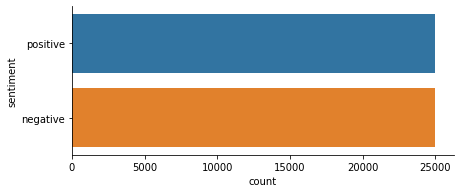

In [11]:
import seaborn as sns
sns.catplot(y="sentiment", kind="count",  data=review_df, height=2.6, aspect=2.5, orient='h')

We see that the dataset is balanced and has an equal number of negative and positive reviews.

At first, we will set a baseline by doing the classification with a simple neural network. Before going ahead we have to preprocess the raw reviews and also convert the words to vectors or embeddings. We will use the Glove vectors for this purpose.

### Preprocessing text

In [12]:
#importing some more libraries

import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


Let's check some of the entries in our dataset so that we can understand what kind of preprocessing would be required.

In [13]:
review_df['review'][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [14]:
review_df['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

We can see that there are some punctuations, brackets, HTML tags etc.

In [15]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [16]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

Let's apply the preprocessing to our dataset and store the resulting reviwes in a list.

In [17]:
X = []

X = []
sentences = list(review_df['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [18]:
X[5]

'Probably my all time favorite movie story of selflessness sacrifice and dedication to noble cause but it not preachy or boring It just never gets old despite my having seen it some or more times in the last years Paul Lukas performance brings tears to my eyes and Bette Davis in one of her very few truly sympathetic roles is delight The kids are as grandma says more like dressed up midgets than children but that only makes them more fun to watch And the mother slow awakening to what happening in the world and under her own roof is believable and startling If had dozen thumbs they all be up for this movie '

Now let's convert the true labels in to the required format.

In [19]:
y = review_df['sentiment']

In [20]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [21]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [22]:
#test-train split (90-10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=3)

In [23]:
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

100% 457M/458M [00:10<00:00, 38.4MB/s]
100% 458M/458M [00:10<00:00, 47.5MB/s]


In [24]:
!unzip /content/glove-global-vectors-for-word-representation.zip

Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


Let's create the embedding layer for our analysis. We will be using the Glove vector representation here. First let's tokenise the reviews.

In [25]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
#setting max length of reviews to 100
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [27]:
vocab_size

96968

We can see that our text corpus consist of 96968 unique words.

In [28]:
#embeddings using Glove vectors

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [29]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## 1. Simple Neural Network

In [30]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9696800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,706,801
Trainable params: 10,001
Non-trainable params: 9,696,800
_________________________________________________________________


In [33]:
simple = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.1)

Train on 40500 samples, validate on 4500 samples
Epoch 1/6
40500/40500 [==============================] - 3s 70us/step - loss: 0.5860 - acc: 0.6857 - val_loss: 0.5245 - val_acc: 0.7389
Epoch 2/6
40500/40500 [==============================] - 1s 29us/step - loss: 0.4916 - acc: 0.7618 - val_loss: 0.5172 - val_acc: 0.7451
Epoch 3/6
40500/40500 [==============================] - 1s 29us/step - loss: 0.4567 - acc: 0.7845 - val_loss: 0.5162 - val_acc: 0.7500
Epoch 4/6
40500/40500 [==============================] - 1s 29us/step - loss: 0.4420 - acc: 0.7934 - val_loss: 0.5246 - val_acc: 0.7478
Epoch 5/6
40500/40500 [==============================] - 1s 31us/step - loss: 0.4276 - acc: 0.8042 - val_loss: 0.5408 - val_acc: 0.7420
Epoch 6/6
40500/40500 [==============================] - 1s 29us/step - loss: 0.4147 - acc: 0.8107 - val_loss: 0.5305 - val_acc: 0.7478


In [34]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

5000/5000 [==============================] - 0s 60us/step
Test Score: 0.5368110883712769
Test Accuracy: 0.7458000183105469


Seems that we have both an high bias and high variance problem here. Now let's try an LSTM network to see whether we can improve on this.

## 2. LSTM Model

In [35]:
l_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
l_model.add(embedding_layer)
l_model.add(LSTM(128))

l_model.add(Dense(1, activation='sigmoid'))
l_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [36]:
l_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9696800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,814,177
Trainable params: 117,377
Non-trainable params: 9,696,800
_________________________________________________________________


In [37]:
l_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.1)

Train on 40500 samples, validate on 4500 samples
Epoch 1/6
40500/40500 [==============================] - 80s 2ms/step - loss: 0.5254 - acc: 0.7345 - val_loss: 0.4370 - val_acc: 0.7976
Epoch 2/6
40500/40500 [==============================] - 80s 2ms/step - loss: 0.4245 - acc: 0.8036 - val_loss: 0.4055 - val_acc: 0.8131
Epoch 3/6
40500/40500 [==============================] - 79s 2ms/step - loss: 0.3795 - acc: 0.8288 - val_loss: 0.3576 - val_acc: 0.8404
Epoch 4/6
40500/40500 [==============================] - 80s 2ms/step - loss: 0.3515 - acc: 0.8456 - val_loss: 0.3285 - val_acc: 0.8560
Epoch 5/6
40500/40500 [==============================] - 79s 2ms/step - loss: 0.3295 - acc: 0.8567 - val_loss: 0.3321 - val_acc: 0.8529
Epoch 6/6
40500/40500 [==============================] - 80s 2ms/step - loss: 0.3083 - acc: 0.8669 - val_loss: 0.3299 - val_acc: 0.8616


In [38]:
score = l_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

5000/5000 [==============================] - 3s 603us/step
Test Score: 0.3449357908248901
Test Accuracy: 0.8485999703407288


In [39]:
l_model2 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
l_model2.add(embedding_layer)
l_model2.add(LSTM(256))

l_model2.add(Dense(1, activation='sigmoid'))
l_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [40]:
l_model2.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1)

Train on 40500 samples, validate on 4500 samples
Epoch 1/10
40500/40500 [==============================] - 79s 2ms/step - loss: 0.5378 - acc: 0.7283 - val_loss: 0.4349 - val_acc: 0.8069
Epoch 2/10
40500/40500 [==============================] - 78s 2ms/step - loss: 0.4269 - acc: 0.8047 - val_loss: 0.3717 - val_acc: 0.8360
Epoch 3/10
40500/40500 [==============================] - 79s 2ms/step - loss: 0.3684 - acc: 0.8352 - val_loss: 0.3421 - val_acc: 0.8540
Epoch 4/10
40500/40500 [==============================] - 79s 2ms/step - loss: 0.3473 - acc: 0.8461 - val_loss: 0.3389 - val_acc: 0.8524
Epoch 5/10
40500/40500 [==============================] - 78s 2ms/step - loss: 0.3164 - acc: 0.8630 - val_loss: 0.3201 - val_acc: 0.8611
Epoch 6/10
40500/40500 [==============================] - 79s 2ms/step - loss: 0.2969 - acc: 0.8721 - val_loss: 0.3151 - val_acc: 0.8580
Epoch 7/10
40500/40500 [==============================] - 79s 2ms/step - loss: 0.2717 - acc: 0.8846 - val_loss: 0.3296 - val_acc:

In [41]:
score = l_model2.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

5000/5000 [==============================] - 3s 695us/step
Test Score: 0.3401243474960327
Test Accuracy: 0.8560000061988831


In [42]:
l_model3 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
l_model3.add(embedding_layer)
l_model3.add(LSTM(128, return_sequences=True))
l_model3.add(Dropout(0.2))
l_model3.add(LSTM(128))
l_model3.add(Dense(1, activation='sigmoid'))
l_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [43]:
l_model3.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1)

Train on 40500 samples, validate on 4500 samples
Epoch 1/10
40500/40500 [==============================] - 154s 4ms/step - loss: 0.5276 - acc: 0.7294 - val_loss: 0.4371 - val_acc: 0.7951
Epoch 2/10
40500/40500 [==============================] - 152s 4ms/step - loss: 0.4202 - acc: 0.8068 - val_loss: 0.3687 - val_acc: 0.8404
Epoch 3/10
40500/40500 [==============================] - 152s 4ms/step - loss: 0.3760 - acc: 0.8323 - val_loss: 0.3529 - val_acc: 0.8473
Epoch 4/10
40500/40500 [==============================] - 153s 4ms/step - loss: 0.3471 - acc: 0.8465 - val_loss: 0.3368 - val_acc: 0.8558
Epoch 5/10
40500/40500 [==============================] - 153s 4ms/step - loss: 0.3276 - acc: 0.8564 - val_loss: 0.3402 - val_acc: 0.8464
Epoch 6/10
40500/40500 [==============================] - 153s 4ms/step - loss: 0.3047 - acc: 0.8670 - val_loss: 0.3323 - val_acc: 0.8538
Epoch 7/10
40500/40500 [==============================] - 154s 4ms/step - loss: 0.2876 - acc: 0.8770 - val_loss: 0.3088 - v

In [44]:
score = l_model3.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

5000/5000 [==============================] - 6s 1ms/step
Test Score: 0.3249516373157501
Test Accuracy: 0.86080002784729


In [45]:
l_model4 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
l_model4.add(embedding_layer)
l_model4.add(LSTM(512, return_sequences=True))
l_model4.add(Dropout(0.2))
l_model4.add(LSTM(256))
l_model4.add(Dense(1, activation='sigmoid'))
l_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [46]:
l_model4.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1)

Train on 40500 samples, validate on 4500 samples
Epoch 1/10
40500/40500 [==============================] - 167s 4ms/step - loss: 0.6543 - acc: 0.6131 - val_loss: 0.6811 - val_acc: 0.5480
Epoch 2/10
40500/40500 [==============================] - 166s 4ms/step - loss: 0.5071 - acc: 0.7445 - val_loss: 0.4084 - val_acc: 0.8153
Epoch 3/10
40500/40500 [==============================] - 166s 4ms/step - loss: 0.3987 - acc: 0.8167 - val_loss: 0.3626 - val_acc: 0.8373
Epoch 4/10
40500/40500 [==============================] - 164s 4ms/step - loss: 0.3720 - acc: 0.8318 - val_loss: 0.3449 - val_acc: 0.8480
Epoch 5/10
40500/40500 [==============================] - 165s 4ms/step - loss: 0.3465 - acc: 0.8472 - val_loss: 0.3291 - val_acc: 0.8551
Epoch 6/10
40500/40500 [==============================] - 164s 4ms/step - loss: 0.3296 - acc: 0.8562 - val_loss: 0.3287 - val_acc: 0.8564
Epoch 7/10
40500/40500 [==============================] - 165s 4ms/step - loss: 0.3107 - acc: 0.8642 - val_loss: 0.3085 - v

In [47]:
score = l_model4.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

5000/5000 [==============================] - 9s 2ms/step
Test Score: 0.35006271376609804
Test Accuracy: 0.8610000014305115


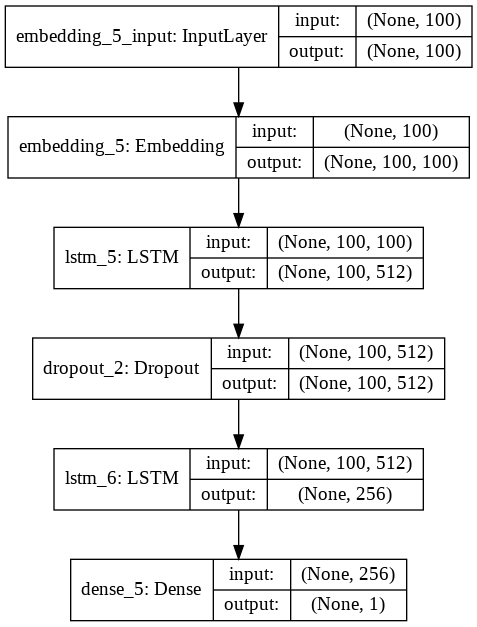

In [48]:
from keras.utils.vis_utils import plot_model
plot_model(l_model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)